In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
DATA = Path('data')
RAW  = DATA/'raw'
SUBMISSIONS = DATA/'submissions'

In [3]:
train      = pd.read_csv(RAW/'train_jqd04QH.csv', low_memory=False)
test       = pd.read_csv(RAW/'test_GYi4Gz5.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)

In [4]:
id_col = 'enrollee_id'
cat_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
            'education_level', 'major_discipline', 'experience', 'company_size', 
            'company_type', 'last_new_job']
num_cols = ['city_development_index', 'training_hours']
target_col = 'target'

In [11]:
train.isnull().sum(0).sort_values(ascending=False)

company_type              5039
company_size              4779
gender                    4098
major_discipline          2838
education_level            457
last_new_job               367
enrolled_university        342
experience                  59
target                       0
training_hours               0
relevent_experience          0
city_development_index       0
city                         0
enrollee_id                  0
dtype: int64

In [6]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [7]:
train.major_discipline.value_counts()

STEM               13738
Humanities           688
Other                343
Business Degree      307
Arts                 239
No Major             206
Name: major_discipline, dtype: int64

In [14]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [17]:
train.loc[10516]

enrollee_id                                18009
city                                    city_103
city_development_index                      0.92
gender                                       NaN
relevent_experience       No relevent experience
enrolled_university                          NaN
education_level                              NaN
major_discipline                             NaN
experience                                    <1
company_size                                 NaN
company_type                                 NaN
last_new_job                                 NaN
training_hours                                43
target                                         0
Name: 10516, dtype: object

In [20]:
train.loc[0]

enrollee_id                                 23798
city                                     city_149
city_development_index                      0.689
gender                                       Male
relevent_experience       Has relevent experience
enrolled_university                 no_enrollment
education_level                          Graduate
major_discipline                             STEM
experience                                      3
company_size                              100-500
company_type                              Pvt Ltd
last_new_job                                    1
training_hours                                106
target                                          0
Name: 0, dtype: object

In [23]:
train.major_discipline.value_counts()

STEM               13738
Humanities           688
Other                343
Business Degree      307
Arts                 239
No Major             206
Name: major_discipline, dtype: int64

In [24]:
train.gender.value_counts()

Male      12884
Female     1188
Other       189
Name: gender, dtype: int64

In [8]:
test.gender.value_counts()

Male      10578
Female      897
Other       158
Name: gender, dtype: int64

In [29]:
train[train.gender=='Male'].major_discipline.value_counts() / 12884  * 100

STEM               76.001242
Humanities          3.469419
Other               1.746352
Business Degree     1.692021
No Major            1.203043
Arts                1.164235
Name: major_discipline, dtype: float64

In [30]:
train[train.gender=='Female'].major_discipline.value_counts() / 1188 * 100

STEM               75.252525
Humanities          9.511785
Other               3.114478
Arts                2.861953
Business Degree     1.599327
No Major            1.010101
Name: major_discipline, dtype: float64

In [32]:
train[train.gender=='Other'].major_discipline.value_counts() / 189 * 100

STEM               57.671958
Humanities          5.291005
Other               3.703704
Arts                3.174603
No Major            2.116402
Business Degree     1.587302
Name: major_discipline, dtype: float64

In [7]:
def get_dict(labels):
    return {label: idx for idx, label in enumerate(labels)}

labels = {
    'enrolled_university': get_dict(['no_enrollment', 'Part time course',
                                     'Full time course']),
    'education_level': get_dict(['Primary School', 'High School', 
                                 'Graduate', 'Masters', 'Phd']),
    'experience': get_dict(['<1'] + \
                           [str(x) for x in range(1,21)] + ['>20']),
    'company_size': get_dict(['<10', '10/49', '50-99', '100-500', 
                              '500-999', 
                              '1000-4999', '5000-9999', '10000+']),
    'last_new_job': get_dict([str(x) for x in range(1,5)] + \
                             ['>4', 'never'])
}

In [67]:
data = pd.concat([train.drop(target_col, axis=1), test])

In [68]:
for col in labels:
    data[f'{col}_num'] = data[col].map(labels[col])

In [22]:
train.isnull().sum(0).sort_values(ascending=False)

company_type              5039
company_size              4779
gender                    4098
major_discipline          2838
education_level            457
last_new_job               367
enrolled_university        342
experience                  59
target                       0
training_hours               0
relevent_experience          0
city_development_index       0
city                         0
enrollee_id                  0
dtype: int64

In [70]:
data.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'enrolled_university_num',
       'education_level_num', 'experience_num', 'company_size_num',
       'last_new_job_num'],
      dtype='object')

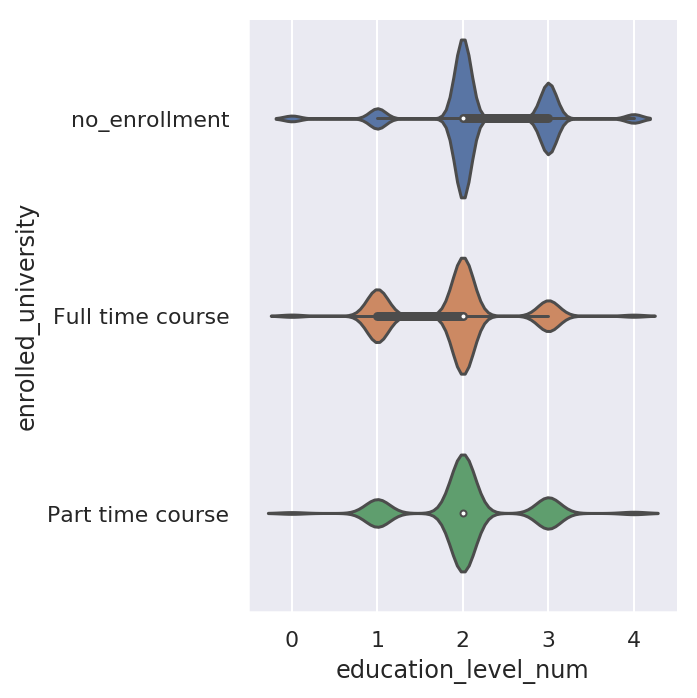

In [97]:
sns.catplot(x="education_level_num", y='enrolled_university',
            kind="violin", data=data)

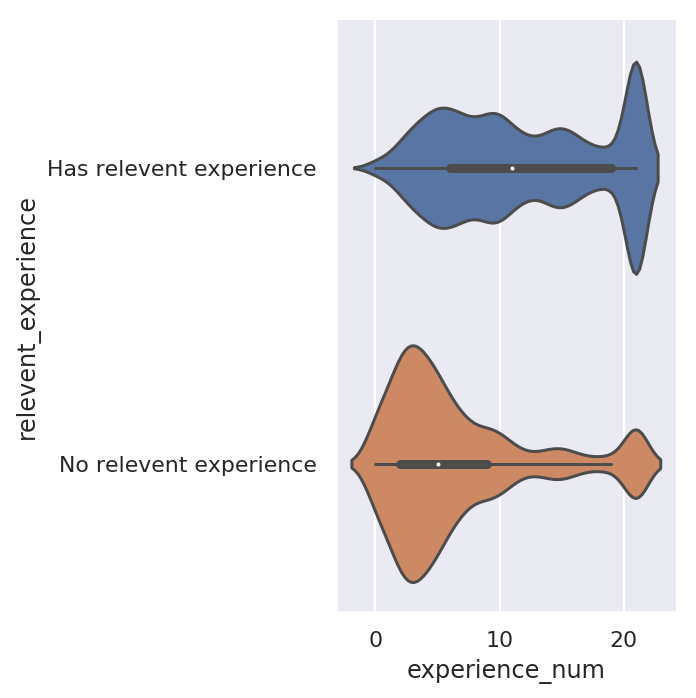

In [83]:
sns.catplot(x="experience_num", y='relevent_experience',
            kind="violin", data=data)

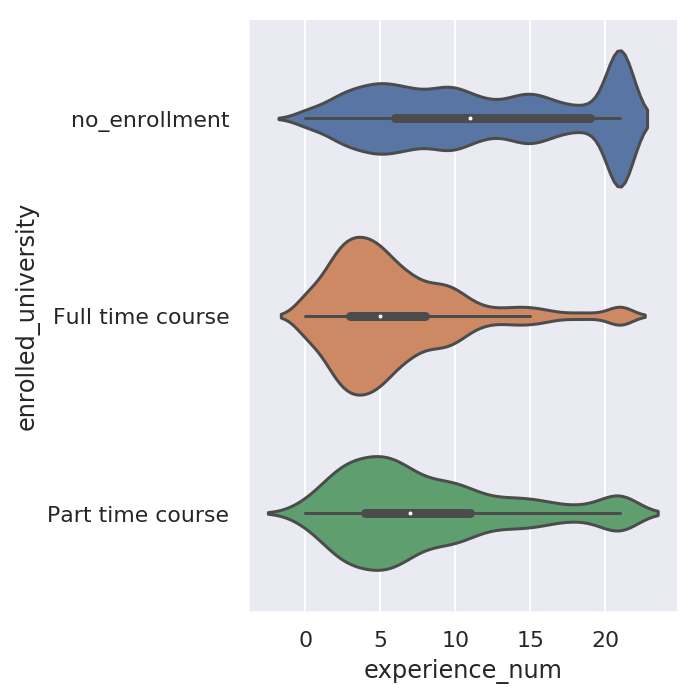

In [20]:
sns.catplot(x="experience_num", y="enrolled_university", 
            kind="violin", data=data)

In [ ]:
# company_size_num <= education_level, major_discipline, experience

In [49]:
company_sizes = {e: data[data.education_level == e].company_size_num.median() for e in data.education_level.unique() if e == e}

In [50]:
company_sizes

{'Graduate': 3.0,
 'High School': 2.0,
 'Masters': 3.0,
 'Phd': 4.0,
 'Primary School': 2.0}

In [60]:
data['company_size_num'] = [company_sizes[e] if c != c and e == e else c for c, e in \
                            zip(data.company_size_num, data.education_level)]

In [61]:
data.company_size_num.value_counts() / data.company_size_num.value_counts().sum() * 100

3.0    31.963943
2.0    24.877425
7.0    11.164235
1.0     8.112800
5.0     7.652952
0.0     7.503731
4.0     5.490757
6.0     3.234157
Name: company_size_num, dtype: float64

In [53]:
data.company_size_num.value_counts() / data.company_size_num.value_counts().sum() * 100

2.0    23.205703
3.0    19.735234
7.0    14.932790
1.0    10.851324
5.0    10.236253
0.0    10.036660
4.0     6.676171
6.0     4.325866
Name: company_size_num, dtype: float64

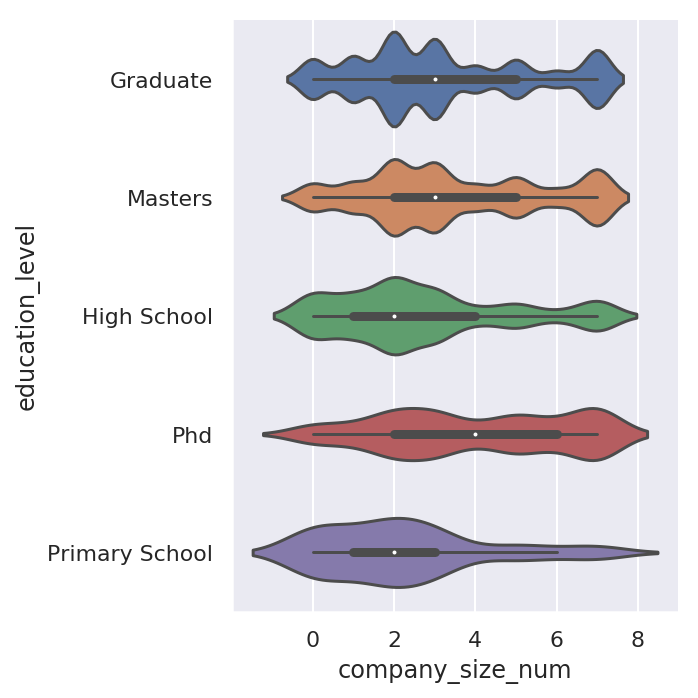

In [45]:
sns.catplot(x="company_size_num", y="education_level", 
            kind="violin", data=data)

In [65]:
data.isnull().sum(0).sort_values(ascending=False)

company_type              9369
company_size              8830
gender                    7486
major_discipline          5231
education_level            852
last_new_job               671
enrolled_university        621
experience                 103
training_hours               0
relevent_experience          0
city_development_index       0
city                         0
enrollee_id                  0
dtype: int64

In [63]:
data.isnull().sum(0).sort_values(ascending=False)

company_type               9369
company_size               8830
gender                     7486
major_discipline           5231
education_level             852
education_level_num         852
last_new_job_num            671
last_new_job                671
enrolled_university_num     621
enrolled_university         621
company_size_num            543
experience                  103
experience_num              103
training_hours                0
relevent_experience           0
city_development_index        0
city                          0
enrollee_id                   0
dtype: int64